In [1]:
import os
import math
import random
import joblib
import config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm


from utils import (
    create_img_grid,
    create_img_stack,
    extract_flxion_features,
    SpatialProjection
)


from model.projectionnet.tf import ProjectionNet

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3" 

import tensorflow as tf


In [2]:
data_dir = "../../../data/dataset/raw/"
subjects = os.listdir(data_dir)

augmentation_levels = [0, 3, 5, 7, 9, 11, 13]
sp_augment = [
    SpatialProjection(
    img_dir="../../../data/dataset/images/",
    # img_len=math.floor(config.IMG_LEN / 3),
    img_len=config.IMG_LEN * 5,
    polyfit_degree=degree
)
    for degree in augmentation_levels ]

test_subject = "007"


  0%|          | 0/7 [00:00<?, ?it/s]

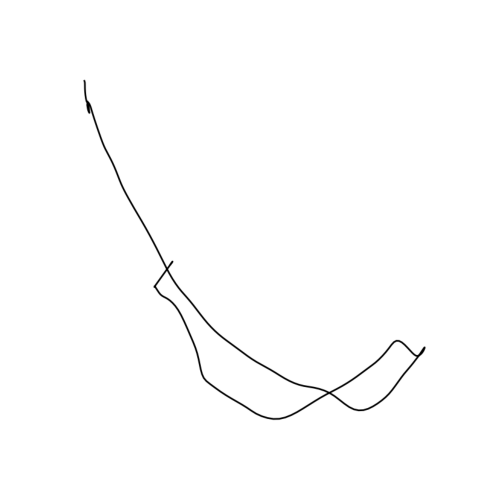

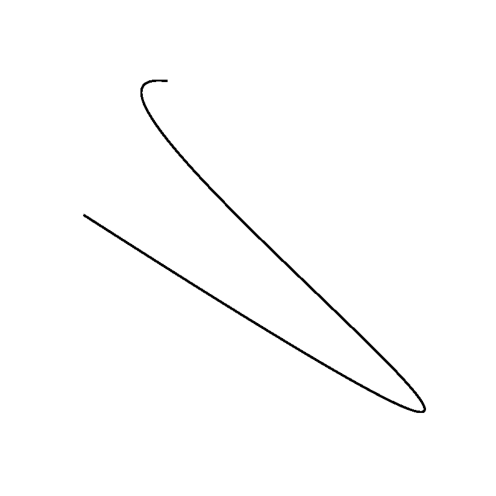

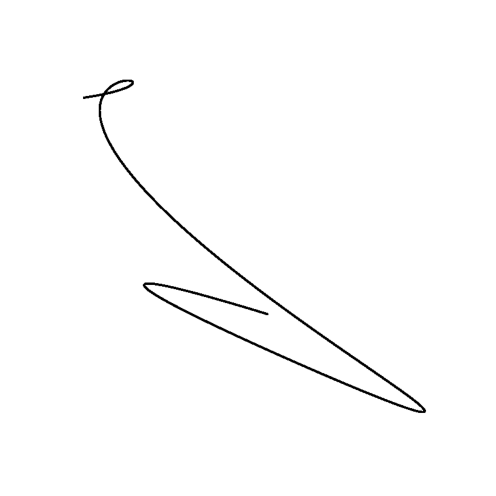

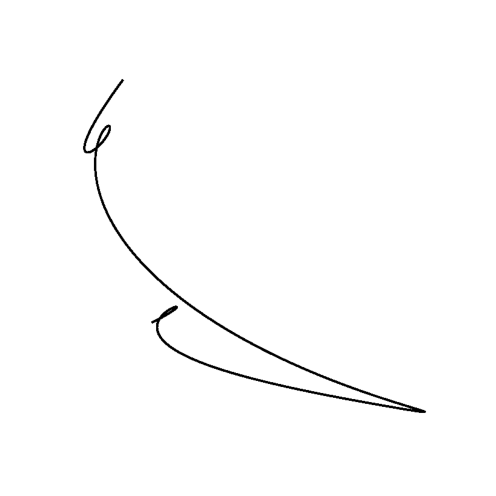

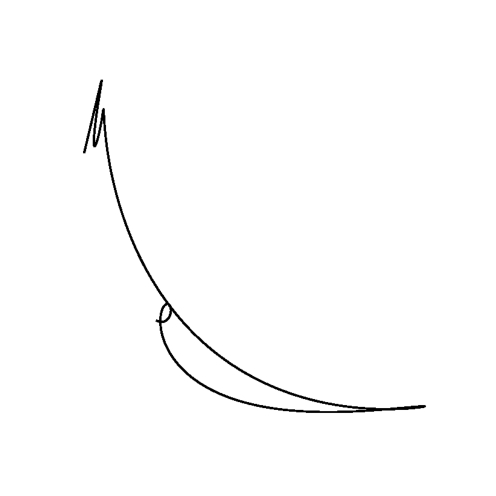

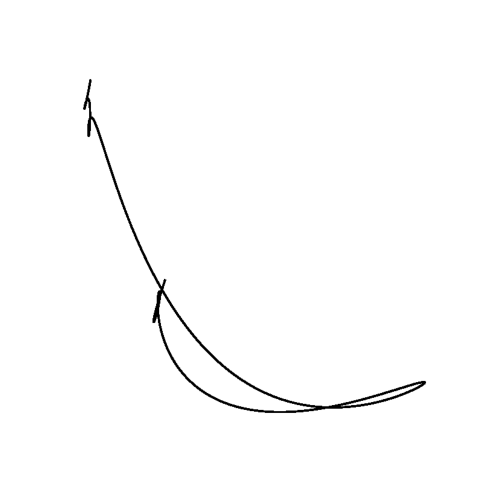

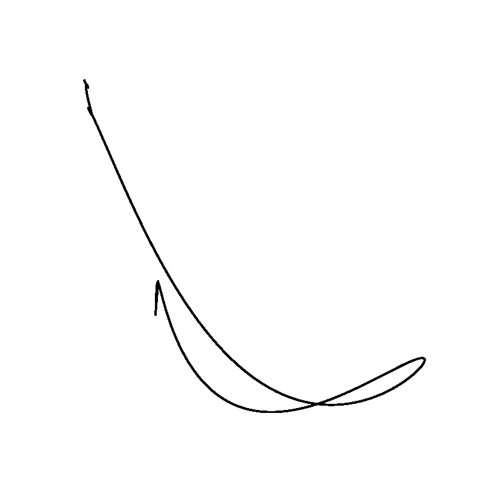

  0%|          | 0/7 [00:02<?, ?it/s]


In [3]:
train_features = []
train_images = []
train_labels = []
test_features = []
test_images = []
test_labels = []

for subject in tqdm(subjects):
    for gesture in config.GESTURES:
        gesture_dir = os.path.join(data_dir, subject, gesture)
        recordings = os.listdir(gesture_dir)
        for recording in recordings:
            file_path = os.path.join(gesture_dir, recording)

            data = pd.read_csv(file_path)
            data.drop(columns=["time"], inplace=True)
            data.drop(0, inplace=True)  # Remove first All-0 row

            if data.shape[0] == 0:
                continue

            # ... Flag for determining Trainning and Testing Samples
            for_training = subject != test_subject
            # for_training = random.randint(1, 100) <= 80

            for sp in sp_augment:
                _images = []
                for landmark in config.PROJECTION_LANDMARKS:
                    _images.extend(
                        sp.get_projection_images(
                            data=data.filter(regex=landmark),
                            subject=subject,
                            gesture=gesture
                        )
                    )

                _features = extract_flxion_features(data)

                # img = create_img_grid(_images, config.IMG_LEN)
                img = create_img_stack(_images[:3])

                if for_training:
                    train_features.append(_features)
                    train_images.append(img)
                    train_labels.append(config.GESTURES.index(gesture))
                else:
                    test_features.append(_features)
                    test_images.append(img)
                    test_labels.append(config.GESTURES.index(gesture))
                    break

                plt.figure(figsize=(7, 7))
                plt.imshow(img[:, :, :, 1])
                plt.axis("off")
                plt.tight_layout()
                plt.savefig(f"../../assets/projection_img_lmc_yz_{sp.polyfit_degree}.svg")
                plt.show()

            break
        break
    break


In [7]:
gesture

'Good'

# Stack CNN Config

In [ ]:
train_features = np.array(train_features)
train_images = np.array(train_images, dtype="uint8")
test_features = np.array(test_features)
test_images = np.array(test_images, dtype="uint8")

X_train = np.split(train_features, len(config.DIST_FEATURES), axis=-1) + \
    [np.squeeze(img) for img in np.split(train_images, 3, axis=-1)]

X_test = np.split(test_features, len(config.DIST_FEATURES), axis=-1) + \
    [np.squeeze(img) for img in np.split(test_images, 3, axis=-1)]

y_train = np.array(train_labels, dtype="uint8")
y_test = np.array(test_labels, dtype="uint8")

print(X_train[0].shape)
print(X_train[-1].shape)
print(X_test[0].shape)
print(X_test[-1].shape)
print(y_train.shape)
print(y_test.shape)


In [ ]:
save_dir = f"../../../data/dataset/processed/{test_subject}/"


In [ ]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

joblib.dump(X_train, os.path.join(save_dir, "X_train_stack_9.joblib"))
joblib.dump(y_train, os.path.join(save_dir, "y_train_stcak_9.joblib"))
joblib.dump(X_test, os.path.join(save_dir, "X_test_stack_9.joblib"))
joblib.dump(y_test, os.path.join(save_dir, "y_test_stack_9.joblib"))

In [ ]:
X_train = joblib.load(os.path.join(save_dir, "X_train_stack_9.joblib"))
y_train = joblib.load(os.path.join(save_dir, "y_train_stcak_9.joblib"))
X_test = joblib.load(os.path.join(save_dir, "X_test_stack_9.joblib"))
y_test = joblib.load(os.path.join(save_dir, "y_test_stack_9.joblib"))

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(config.IMG_LEN, config.IMG_LEN, config.N_CHANNELS),
    include_top=False,
    weights="imagenet"
)

model = ProjectionNet(
    img_size=config.IMG_LEN,
    segment_len=config.SEGMENT_LEN,
    n_classes=len(config.GESTURES),
    base_model=base_model
).get_model(
    n_projections=config.N_CHANNELS,
    n_channels=len(config.DIST_FEATURES)
)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True
    )
]

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=100,
    verbose=1,
    callbacks=callbacks
)


In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    # "text.usetex": True,
    "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "font.size": 22,
    "text.color": "#212121",
    "axes.edgecolor": "#212121",
    "xtick.color": "#212121",
    "ytick.color": "#212121",
    "axes.labelcolor": "#212121",
    'legend.frameon': False,
})

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax.plot(history.history["loss"], "-", color="#212121", label="Train Loss")
ax.plot(history.history["val_loss"], "--",
        color="#212121", label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Learning Curves")
plt.legend()
plt.tight_layout()
plt.savefig("../assets/lc.png")
plt.show()


In [ ]:
# tf.keras.backend.clear_session()
